In [84]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.mixture
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import tree, neural_network, preprocessing, ensemble, svm, neighbors, cluster
from imblearn.under_sampling import RandomUnderSampler
import graphviz
from sklearn.model_selection import train_test_split,KFold, ShuffleSplit,RepeatedStratifiedKFold
from sklearn.metrics import *
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.model_selection import cross_val_score
from statistics import mode
from scipy.stats import norm, kurtosis
from scipy import stats as s
import time
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv(r'fraud_oracle.csv')

In [4]:
df2 = pd.read_csv('auto_claim.csv')

In [5]:
variables = list(df.columns)
feature_name = variables.copy()
feature_name.remove('FraudFound_P')

In [6]:
numeric_names = ['WeekOfMonth','WeekOfMonthClaimed','Age','Deductible','DriverRating','Year','PolicyNumber','RepNumber']
convert_names = [ele for ele in feature_name if ele not in numeric_names]

In [7]:
character_converted = pd.DataFrame()
for variable in convert_names:
    character_converted[variable] = preprocessing.LabelEncoder().fit_transform(df[variable])
standard_scaler = preprocessing.StandardScaler()
character_scaled = pd.DataFrame(standard_scaler.fit_transform(character_converted),columns=convert_names)

In [8]:
numeric_raw = df[['WeekOfMonth','WeekOfMonthClaimed','Age','Deductible','DriverRating','Year']].values #returns a numpy array
numeric_scaled = standard_scaler.fit_transform(numeric_raw)
numeric_df = pd.DataFrame(numeric_scaled, columns=['WeekOfMonth','WeekOfMonthClaimed','Age','Deductible','DriverRating','Year'])

In [9]:
X = pd.concat([character_scaled, numeric_df],axis=1)
y = df['FraudFound_P']

In [10]:
X_Train, X_Test, y_Train, y_Test = train_test_split(X, y, test_size=0.3, random_state=1) 

In [11]:
variables2 = list(df2.columns)
feature_name2 = variables2.copy()
feature_name2.remove('policy_id')
feature_name2.remove('is_claim')

In [12]:
numeric_names2 = ['policy_tenure','age_of_car','age_of_policyholder','population_density','airbags','displacement','cylinder','gear_box','turning_radius','length','width','height','gross_weight','ncap_rating']
convert_names2 = [ele for ele in feature_name2 if ele not in numeric_names2]

In [13]:
character_converted2 = pd.DataFrame()
for variable in convert_names2:
    character_converted2[variable] = preprocessing.LabelEncoder().fit_transform(df2[variable])
standard_scaler = preprocessing.StandardScaler()
character_scaled2 = pd.DataFrame(standard_scaler.fit_transform(character_converted2),columns=convert_names2)

In [14]:
numeric_raw2 = df2[numeric_names2].values #returns a numpy array
numeric_scaled2 = standard_scaler.fit_transform(numeric_raw2)
numeric_df2 = pd.DataFrame(numeric_scaled2, columns=numeric_names2)

In [15]:
X2 = pd.concat([character_scaled2, numeric_df2],axis=1)
y2 = df2['is_claim']

In [16]:
X_Train2, X_Test2, y_Train2, y_Test2 = train_test_split(X2, y2, test_size=0.3, random_state=1) 

In [17]:
def cross_validation (X_Train,y_Train, group, clf):
    test_agg_accu = 0
    test_agg_auc = 0
    train_agg_accu = 0
    train_agg_auc = 0
    training_time_sum = 0
    for train_index, test_index in group.split(X_Train):
        X_train, X_test = X_Train.iloc[train_index], X_Train.iloc[test_index]
        Y_train, Y_test = y_Train.iloc[train_index], y_Train.iloc[test_index]
        start = time.time()
        clf = clf.fit( X_train,Y_train)
        stop = time.time()
        training_time = stop - start
        training_time_sum += training_time
        Y_pred = clf.predict(X_test)
        Y_pred_train = clf.predict(X_train)
        test_accuracy = accuracy_score(Y_test , Y_pred)
        test_auc = roc_auc_score(Y_test , Y_pred)
        train_accuracy = accuracy_score(Y_train , Y_pred_train)
        train_auc = roc_auc_score(Y_train , Y_pred_train)
        test_agg_accu = test_agg_accu+ test_accuracy
        test_agg_auc = test_agg_auc + test_auc
        train_agg_accu = train_agg_accu + train_accuracy
        train_agg_auc = train_agg_auc + train_auc
    test_avg_accu = test_agg_accu/k
    test_avg_auc = test_agg_auc/k
    train_avg_accu = train_agg_accu/k
    train_avg_auc = train_agg_auc/k
    
    return test_avg_accu, test_avg_auc, train_avg_accu, train_avg_auc, training_time_sum

### clustering

#### (1) dataset 1

In [ ]:
silhouette_scores = []
gains = []
for i in range(2, 11):
    kmeans = sklearn.cluster.KMeans(n_clusters=i, init='random',n_init=10, max_iter=300, tol=1e-04, random_state=0)
    kmeans.fit(X)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    y_km = kmeans.fit_predict(X)
    result_compare = pd.DataFrame()
    result_compare['fitted'] = y_km
    result_compare['actual'] = y
    selected_group = mode(result_compare[result_compare.actual==1]['fitted'])
    gain = result_compare[result_compare.fitted == selected_group]['actual'].sum() / result_compare[result_compare.fitted == selected_group]['actual'].count() / (result_compare['actual'].sum() / result_compare['actual'].count()) 
    gains.append(gain)

In [ ]:
fig,ax = plt.subplots()
plt.title('Silhouette Analysis - KMeans')
# make a plot
ax.plot(range(2, 11),
        silhouette_scores,color="orange")
# set x-axis label
ax.set_xlabel("Number of clusters", fontsize = 14)
# set y-axis label
ax.set_ylabel("Silhouette score",
              color="orange",
              fontsize=14)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(range(2, 11), gains,color="blue")
ax2.set_ylabel("classification power",color="blue",fontsize=14)
plt.show()

In [ ]:
silhouette_scores = []
gains = []
aics = []
for i in range(2, 11):
    em = sklearn.mixture.GaussianMixture(n_components=i, covariance_type='tied',n_init=10, max_iter=300)
    em.fit(X)
    aic = em.aic(X)
    y_km = em.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, y_km))
    result_compare = pd.DataFrame()
    result_compare['fitted'] = y_km
    result_compare['actual'] = y
    selected_group = mode(result_compare[result_compare.actual==1]['fitted'])
    gain = result_compare[result_compare.fitted == selected_group]['actual'].sum() / result_compare[result_compare.fitted == selected_group]['actual'].count() / (result_compare['actual'].sum() / result_compare['actual'].count()) 
    gains.append(gain)
    aics.append(aic)

In [ ]:
fig,ax = plt.subplots()
plt.title('Silhouette Analysis - EM - tied')
# make a plot
ax.plot(range(2, 11),
        silhouette_scores,color="orange")
# set x-axis label
ax.set_xlabel("Number of clusters", fontsize = 14)
# set y-axis label
ax.set_ylabel("Silhouette score",
              color="orange",
              fontsize=14)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(range(2, 11), gains,color="blue")
ax2.set_ylabel("classification power",color="blue",fontsize=14)
plt.show()

In [ ]:
silhouette_scores = []
gains = []
aics = []
for i in range(2, 11):
    em = sklearn.mixture.GaussianMixture(n_components=i, covariance_type='full',n_init=10, max_iter=300)
    em.fit(X)
    aic = em.aic(X)
    y_km = em.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, y_km))
    result_compare = pd.DataFrame()
    result_compare['fitted'] = y_km
    result_compare['actual'] = y
    selected_group = mode(result_compare[result_compare.actual==1]['fitted'])
    gain = result_compare[result_compare.fitted == selected_group]['actual'].sum() / result_compare[result_compare.fitted == selected_group]['actual'].count() / (result_compare['actual'].sum() / result_compare['actual'].count()) 
    gains.append(gain)
    aics.append(aic)

In [ ]:
fig,ax = plt.subplots()
plt.title('Silhouette Analysis - EM - full')
# make a plot
ax.plot(range(2, 11),
        silhouette_scores,color="orange")
# set x-axis label
ax.set_xlabel("Number of clusters", fontsize = 14)
# set y-axis label
ax.set_ylabel("Silhouette score",
              color="orange",
              fontsize=14)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(range(2, 11), gains,color="blue")
ax2.set_ylabel("classification power",color="blue",fontsize=14)
plt.show()

In [ ]:
silhouette_scores = []
gains = []
aics = []
for i in range(2, 11):
    em = sklearn.mixture.GaussianMixture(n_components=i, covariance_type='diag',n_init=10, max_iter=300)
    em.fit(X)
    aic = em.aic(X)
    y_km = em.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, y_km))
    result_compare = pd.DataFrame()
    result_compare['fitted'] = y_km
    result_compare['actual'] = y
    selected_group = mode(result_compare[result_compare.actual==1]['fitted'])
    gain = result_compare[result_compare.fitted == selected_group]['actual'].sum() / result_compare[result_compare.fitted == selected_group]['actual'].count() / (result_compare['actual'].sum() / result_compare['actual'].count()) 
    gains.append(gain)
    aics.append(aic)

In [ ]:
fig,ax = plt.subplots()
plt.title('Silhouette Analysis - EM - diag')
# make a plot
ax.plot(range(2, 11),
        silhouette_scores,color="orange")
# set x-axis label
ax.set_xlabel("Number of clusters", fontsize = 14)
# set y-axis label
ax.set_ylabel("Silhouette score",
              color="orange",
              fontsize=14)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(range(2, 11), gains,color="blue")
ax2.set_ylabel("classification power",color="blue",fontsize=14)
plt.show()

In [ ]:
silhouette_scores = []
gains = []
aics = []
for i in range(2, 11):
    em = sklearn.mixture.GaussianMixture(n_components=i, covariance_type='spherical',n_init=10, max_iter=300)
    em.fit(X)
    aic = em.aic(X)
    y_km = em.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, y_km))
    result_compare = pd.DataFrame()
    result_compare['fitted'] = y_km
    result_compare['actual'] = y
    selected_group = mode(result_compare[result_compare.actual==1]['fitted'])
    gain = result_compare[result_compare.fitted == selected_group]['actual'].sum() / result_compare[result_compare.fitted == selected_group]['actual'].count() / (result_compare['actual'].sum() / result_compare['actual'].count()) 
    gains.append(gain)
    aics.append(aic)

In [ ]:
fig,ax = plt.subplots()
plt.title('Silhouette Analysis - EM - spherical')
# make a plot
ax.plot(range(2, 11),
        silhouette_scores,color="orange")
# set x-axis label
ax.set_xlabel("Number of clusters", fontsize = 14)
# set y-axis label
ax.set_ylabel("Silhouette score",
              color="orange",
              fontsize=14)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(range(2, 11), gains,color="blue")
ax2.set_ylabel("classification power",color="blue",fontsize=14)
plt.show()

#### (2) dataset2

In [ ]:
silhouette_scores = []
gains = []
for i in range(2, 11):
    kmeans = sklearn.cluster.KMeans(n_clusters=i, init='random',n_init=10, max_iter=300, tol=1e-04, random_state=0)
    kmeans.fit(X2)
    silhouette_scores.append(silhouette_score(X2, kmeans.labels_))
    y_km = kmeans.fit_predict(X2)
    result_compare = pd.DataFrame()
    result_compare['fitted'] = y_km
    result_compare['actual'] = y2
    selected_group = mode(result_compare[result_compare.actual==1]['fitted'])
    gain = result_compare[result_compare.fitted == selected_group]['actual'].sum() / result_compare[result_compare.fitted == selected_group]['actual'].count() / (result_compare['actual'].sum() / result_compare['actual'].count()) 
    gains.append(gain)

In [ ]:
fig,ax = plt.subplots()
plt.title('Silhouette Analysis - KMeans')
# make a plot
ax.plot(range(2, 11),
        silhouette_scores,color="orange")
# set x-axis label
ax.set_xlabel("Number of clusters", fontsize = 14)
# set y-axis label
ax.set_ylabel("Silhouette score",
              color="orange",
              fontsize=14)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(range(2, 11), gains,color="blue")
ax2.set_ylabel("classification power",color="blue",fontsize=14)
plt.show()

In [ ]:
silhouette_scores = []
gains = []
aics = []
for i in range(2, 11):
    em = sklearn.mixture.GaussianMixture(n_components=i, covariance_type='tied',n_init=10, max_iter=300)
    em.fit(X2)
    aic = em.aic(X2)
    y_km = em.fit_predict(X2)
    silhouette_scores.append(silhouette_score(X2, y_km))
    result_compare = pd.DataFrame()
    result_compare['fitted'] = y_km
    result_compare['actual'] = y2
    selected_group = mode(result_compare[result_compare.actual==1]['fitted'])
    gain = result_compare[result_compare.fitted == selected_group]['actual'].sum() / result_compare[result_compare.fitted == selected_group]['actual'].count() / (result_compare['actual'].sum() / result_compare['actual'].count()) 
    gains.append(gain)
    aics.append(aic)

In [ ]:
fig,ax = plt.subplots()
plt.title('Silhouette Analysis - EM - tied')
# make a plot
ax.plot(range(2, 11),
        silhouette_scores,color="orange")
# set x-axis label
ax.set_xlabel("Number of clusters", fontsize = 14)
# set y-axis label
ax.set_ylabel("Silhouette score",
              color="orange",
              fontsize=14)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(range(2, 11), gains,color="blue")
ax2.set_ylabel("classification power",color="blue",fontsize=14)
plt.show()

In [ ]:
silhouette_scores = []
gains = []
aics = []
for i in range(2, 11):
    em = sklearn.mixture.GaussianMixture(n_components=i, covariance_type='full',n_init=10, max_iter=300)
    em.fit(X2)
    aic = em.aic(X2)
    y_km = em.fit_predict(X2)
    silhouette_scores.append(silhouette_score(X2, y_km))
    result_compare = pd.DataFrame()
    result_compare['fitted'] = y_km
    result_compare['actual'] = y2
    selected_group = mode(result_compare[result_compare.actual==1]['fitted'])
    gain = result_compare[result_compare.fitted == selected_group]['actual'].sum() / result_compare[result_compare.fitted == selected_group]['actual'].count() / (result_compare['actual'].sum() / result_compare['actual'].count()) 
    gains.append(gain)
    aics.append(aic)

In [ ]:
fig,ax = plt.subplots()
plt.title('Silhouette Analysis - EM - full')
# make a plot
ax.plot(range(2, 11),
        silhouette_scores,color="orange")
# set x-axis label
ax.set_xlabel("Number of clusters", fontsize = 14)
# set y-axis label
ax.set_ylabel("Silhouette score",
              color="orange",
              fontsize=14)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(range(2, 11), gains,color="blue")
ax2.set_ylabel("classification power",color="blue",fontsize=14)
plt.show()

In [ ]:
silhouette_scores = []
gains = []
aics = []
for i in range(2, 11):
    em = sklearn.mixture.GaussianMixture(n_components=i, covariance_type='diag',n_init=10, max_iter=300)
    em.fit(X2)
    aic = em.aic(X2)
    y_km = em.fit_predict(X2)
    silhouette_scores.append(silhouette_score(X2, y_km))
    result_compare = pd.DataFrame()
    result_compare['fitted'] = y_km
    result_compare['actual'] = y2
    selected_group = mode(result_compare[result_compare.actual==1]['fitted'])
    gain = result_compare[result_compare.fitted == selected_group]['actual'].sum() / result_compare[result_compare.fitted == selected_group]['actual'].count() / (result_compare['actual'].sum() / result_compare['actual'].count()) 
    gains.append(gain)
    aics.append(aic)

In [ ]:
fig,ax = plt.subplots()
plt.title('Silhouette Analysis - EM - diag')
# make a plot
ax.plot(range(2, 11),
        silhouette_scores,color="orange")
# set x-axis label
ax.set_xlabel("Number of clusters", fontsize = 14)
# set y-axis label
ax.set_ylabel("Silhouette score",
              color="orange",
              fontsize=14)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(range(2, 11), gains,color="blue")
ax2.set_ylabel("classification power",color="blue",fontsize=14)
plt.show()

In [ ]:
silhouette_scores = []
gains = []
aics = []
for i in range(2, 11):
    em = sklearn.mixture.GaussianMixture(n_components=i, covariance_type='spherical',n_init=10, max_iter=300)
    em.fit(X2)
    aic = em.aic(X2)
    y_km = em.fit_predict(X2)
    silhouette_scores.append(silhouette_score(X2, y_km))
    result_compare = pd.DataFrame()
    result_compare['fitted'] = y_km
    result_compare['actual'] = y2
    selected_group = mode(result_compare[result_compare.actual==1]['fitted'])
    gain = result_compare[result_compare.fitted == selected_group]['actual'].sum() / result_compare[result_compare.fitted == selected_group]['actual'].count() / (result_compare['actual'].sum() / result_compare['actual'].count()) 
    gains.append(gain)
    aics.append(aic)

In [ ]:
fig,ax = plt.subplots()
plt.title('Silhouette Analysis - EM - spherical')
# make a plot
ax.plot(range(2, 11),
        silhouette_scores,color="orange")
# set x-axis label
ax.set_xlabel("Number of clusters", fontsize = 14)
# set y-axis label
ax.set_ylabel("Silhouette score",
              color="orange",
              fontsize=14)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(range(2, 11), gains,color="blue")
ax2.set_ylabel("classification power",color="blue",fontsize=14)
plt.show()

### Dimensionality Reduction

#### (1) dataset1

In [126]:
rus = RandomUnderSampler(random_state=42)

# Resample the data
X_resampled, y_resampled = rus.fit_resample(X2, y2)

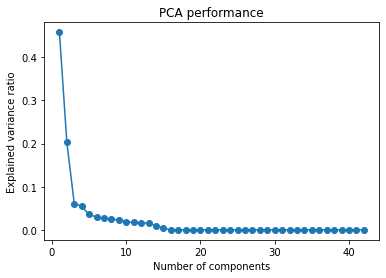

In [127]:
pca = PCA()

# Fit the PCA model to the data and transform it
X_pca = pca.fit_transform(X_resampled)

# Plot the scree plot
plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')
plt.title('PCA performance')
plt.show()

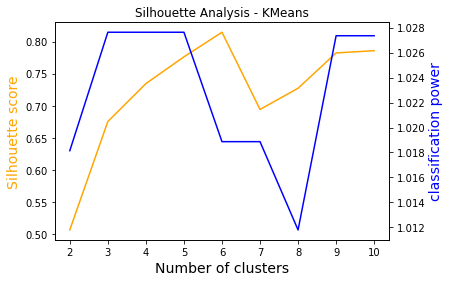

In [137]:
pca = PCA(n_components=5)
# Fit the PCA model to the data and transform it
X_pca = pca.fit_transform(X_resampled)
X_reconstructed = np.dot(X_pca, pca.components_)
reconstruction_error = np.mean(np.sum(np.power(X_resampled - X_reconstructed, 2), axis=1))

silhouette_scores = []
gains = []
for i in range(2, 11):
    kmeans = sklearn.cluster.KMeans(n_clusters=i, init='random',n_init=10, max_iter=300, tol=1e-04, random_state=0)
    kmeans.fit(X_reconstructed)
    silhouette_scores.append(silhouette_score(X_reconstructed, kmeans.labels_))
    y_km = kmeans.fit_predict(X_reconstructed)
    result_compare = pd.DataFrame()
    result_compare['fitted'] = y_km
    result_compare['actual'] = y_resampled
    selected_group = mode(result_compare[result_compare.actual==1]['fitted'])
    gain = result_compare[result_compare.fitted == selected_group]['actual'].sum() / result_compare[result_compare.fitted == selected_group]['actual'].count() / (result_compare['actual'].sum() / result_compare['actual'].count()) 
    gains.append(gain)
    
fig,ax = plt.subplots()
plt.title('Silhouette Analysis - KMeans')
# make a plot
ax.plot(range(2, 11),
        silhouette_scores,color="orange")
# set x-axis label
ax.set_xlabel("Number of clusters", fontsize = 14)
# set y-axis label
ax.set_ylabel("Silhouette score",
              color="orange",
              fontsize=14)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(range(2, 11), gains,color="blue")
ax2.set_ylabel("classification power",color="blue",fontsize=14)
plt.show()

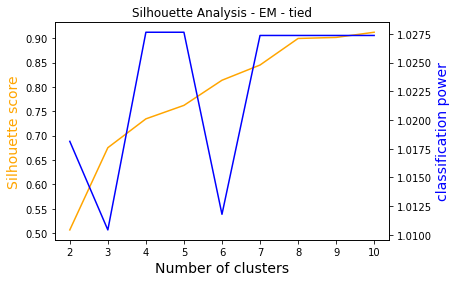

In [138]:
silhouette_scores = []
gains = []
for i in range(2, 11):
    em = sklearn.mixture.GaussianMixture(n_components=i, covariance_type='tied',n_init=10, max_iter=300)
    em.fit(X_reconstructed)
    y_km = em.fit_predict(X_reconstructed)
    silhouette_scores.append(silhouette_score(X_reconstructed, y_km))
    
    result_compare = pd.DataFrame()
    result_compare['fitted'] = y_km
    result_compare['actual'] = y_resampled
    selected_group = mode(result_compare[result_compare.actual==1]['fitted'])
    gain = result_compare[result_compare.fitted == selected_group]['actual'].sum() / result_compare[result_compare.fitted == selected_group]['actual'].count() / (result_compare['actual'].sum() / result_compare['actual'].count()) 
    gains.append(gain)
    
fig,ax = plt.subplots()
plt.title('Silhouette Analysis - EM - tied')
# make a plot
ax.plot(range(2, 11),
        silhouette_scores,color="orange")
# set x-axis label
ax.set_xlabel("Number of clusters", fontsize = 14)
# set y-axis label
ax.set_ylabel("Silhouette score",
              color="orange",
              fontsize=14)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(range(2, 11), gains,color="blue")
ax2.set_ylabel("classification power",color="blue",fontsize=14)
plt.show()

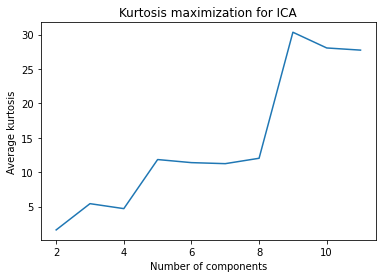

In [139]:
kurt = []
for n_components in range(2, 12):
    ica = FastICA(n_components=n_components, random_state=0)
    S = ica.fit_transform(X_resampled)
    kurt.append(np.mean(np.abs(kurtosis(S, axis=0, fisher=False))))

# Plot the kurtosis values as a function of the number of ICs
plt.plot(range(2, 12), kurt)
plt.xlabel('Number of components')
plt.ylabel('Average kurtosis')
plt.title('Kurtosis maximization for ICA')
plt.show()


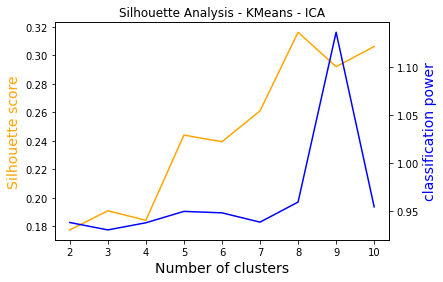

In [140]:
ica = FastICA(n_components=9, random_state=0)
# Fit the PCA model to the data and transform it
X_ica = ica.fit_transform(X_resampled)
X_reconstructed = np.dot(X_ica, ica.components_)
reconstruction_error = np.mean(np.sum(np.power(X_resampled - X_reconstructed, 2), axis=1))

silhouette_scores = []
gains = []
for i in range(2, 11):
    kmeans = sklearn.cluster.KMeans(n_clusters=i, init='random',n_init=10, max_iter=300, tol=1e-04, random_state=0)
    kmeans.fit(X_reconstructed)
    silhouette_scores.append(silhouette_score(X_reconstructed, kmeans.labels_))
    y_km = kmeans.fit_predict(X_reconstructed)
    result_compare = pd.DataFrame()
    result_compare['fitted'] = y_km
    result_compare['actual'] = y_resampled
    selected_group = int(s.mode(result_compare[result_compare.actual==1]['fitted'])[0])
    gain = result_compare[result_compare.fitted == selected_group]['actual'].sum() / result_compare[result_compare.fitted == selected_group]['actual'].count() / (result_compare['actual'].sum() / result_compare['actual'].count()) 
    gains.append(gain)
    
fig,ax = plt.subplots()
plt.title('Silhouette Analysis - KMeans - ICA')
# make a plot
ax.plot(range(2, 11),
        silhouette_scores,color="orange")
# set x-axis label
ax.set_xlabel("Number of clusters", fontsize = 14)
# set y-axis label
ax.set_ylabel("Silhouette score",
              color="orange",
              fontsize=14)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(range(2, 11), gains,color="blue")
ax2.set_ylabel("classification power",color="blue",fontsize=14)
plt.show()

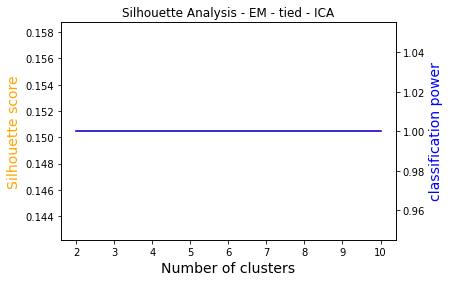

In [148]:
silhouette_scores = []
gains = []
for i in range(2, 11):
    em = sklearn.mixture.GaussianMixture(n_components=i, covariance_type='tied',n_init=10, max_iter=300)
    em.fit(X_reconstructed)
    y_km = em.fit_predict(X_reconstructed)
    if  len(set(y_km)) == 1:
        y_km[0]=y_km[0]+1
    silhouette_scores.append(silhouette_score(X_reconstructed, y_km))
    
    result_compare = pd.DataFrame()
    result_compare['fitted'] = y_km
    result_compare['actual'] = y_resampled
    selected_group = int(s.mode(result_compare[result_compare.actual==1]['fitted'])[0])
    gain = result_compare[result_compare.fitted == selected_group]['actual'].sum() / result_compare[result_compare.fitted == selected_group]['actual'].count() / (result_compare['actual'].sum() / result_compare['actual'].count()) 
    gains.append(gain)
    
fig,ax = plt.subplots()
plt.title('Silhouette Analysis - EM - tied - ICA')
# make a plot
ax.plot(range(2, 11),
        silhouette_scores,color="orange")
# set x-axis label
ax.set_xlabel("Number of clusters", fontsize = 14)
# set y-axis label
ax.set_ylabel("Silhouette score",
              color="orange",
              fontsize=14)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(range(2, 11), gains,color="blue")
ax2.set_ylabel("classification power",color="blue",fontsize=14)
plt.show()

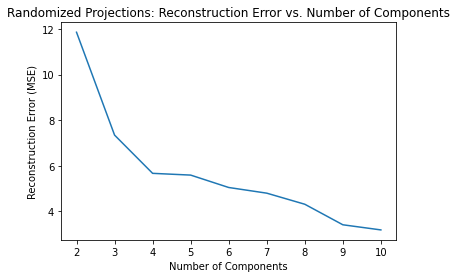

In [149]:
reconstruction_errors = []
for n_components in range(2, 11):
    rp = GaussianRandomProjection(n_components=n_components, random_state=42)
    
    # Reduce the dimensionality
    X_reduced = rp.fit_transform(X_resampled)
    
    # Reconstruct the original dataset
    X_reconstructed = np.dot(X_reduced, rp.components_)
    
    # Compute the reconstruction error (mean squared error)
    mse = mean_squared_error(X_resampled, X_reconstructed)
    reconstruction_errors.append(mse)

# Plot the results
plt.plot(range(2, 11), reconstruction_errors)
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error (MSE)')
plt.title('Randomized Projections: Reconstruction Error vs. Number of Components')
plt.show()

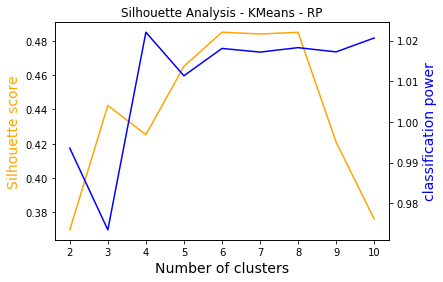

In [159]:
rp = GaussianRandomProjection(n_components=4, random_state=42)
# Fit the PCA model to the data and transform it
X_rp = rp.fit_transform(X_resampled)
X_reconstructed = np.dot(X_rp, rp.components_)
reconstruction_error = np.mean(np.sum(np.power(X_resampled - X_reconstructed, 2), axis=1))

silhouette_scores = []
gains = []

for i in range(2, 11):
    gain_temp = 0
    silhouette_temp = 0
    for n in range(10):
        kmeans = sklearn.cluster.KMeans(n_clusters=i, init='random',n_init=10, max_iter=300, tol=1e-04, random_state=0)
        kmeans.fit(X_reconstructed)
        
        y_km = kmeans.fit_predict(X_reconstructed)
        result_compare = pd.DataFrame()
        result_compare['fitted'] = y_km
        result_compare['actual'] = y_resampled
        selected_group = int(s.mode(result_compare[result_compare.actual==1]['fitted'])[0])
        gain = result_compare[result_compare.fitted == selected_group]['actual'].sum() / result_compare[result_compare.fitted == selected_group]['actual'].count() / (result_compare['actual'].sum() / result_compare['actual'].count()) 
        gain_temp += gain
        silhouette_temp += silhouette_score(X_reconstructed, kmeans.labels_)
        
    gains.append(gain_temp/10)
    silhouette_scores.append(silhouette_temp/10)

fig,ax = plt.subplots()
plt.title('Silhouette Analysis - KMeans - RP')
# make a plot
ax.plot(range(2, 11),
        silhouette_scores,color="orange")
# set x-axis label
ax.set_xlabel("Number of clusters", fontsize = 14)
# set y-axis label
ax.set_ylabel("Silhouette score",
              color="orange",
              fontsize=14)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(range(2, 11), gains,color="blue")
ax2.set_ylabel("classification power",color="blue",fontsize=14)
plt.show()

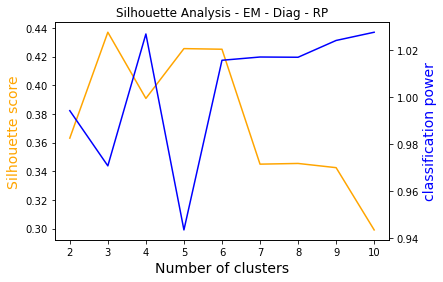

In [160]:
silhouette_scores = []
gains = []

for i in range(2, 11):
    gain_temp = 0
    silhouette_temp = 0
    for n in range(10):
        em = sklearn.mixture.GaussianMixture(n_components=i, covariance_type='diag',n_init=10, max_iter=300)
        em.fit(X_reconstructed)
        y_km = em.fit_predict(X_reconstructed)
        
        result_compare = pd.DataFrame()
        result_compare['fitted'] = y_km
        result_compare['actual'] = y_resampled
        selected_group = int(s.mode(result_compare[result_compare.actual==1]['fitted'])[0])
        gain = result_compare[result_compare.fitted == selected_group]['actual'].sum() / result_compare[result_compare.fitted == selected_group]['actual'].count() / (result_compare['actual'].sum() / result_compare['actual'].count()) 
        gain_temp += gain
        silhouette_temp += silhouette_score(X_reconstructed, y_km)
        
    gains.append(gain_temp/10)
    silhouette_scores.append(silhouette_temp/10)
    
fig,ax = plt.subplots()
plt.title('Silhouette Analysis - EM - Diag - RP')
# make a plot
ax.plot(range(2, 11),
        silhouette_scores,color="orange")
# set x-axis label
ax.set_xlabel("Number of clusters", fontsize = 14)
# set y-axis label
ax.set_ylabel("Silhouette score",
              color="orange",
              fontsize=14)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(range(2, 11), gains,color="blue")
ax2.set_ylabel("classification power",color="blue",fontsize=14)
plt.show()

In [152]:
lda = LinearDiscriminantAnalysis()

# Fit the LDA model to the data and transform it
lda.fit(X_resampled,y_resampled)
X_lda = lda.transform(X_resampled)
y_pred = lda.predict(X_resampled)

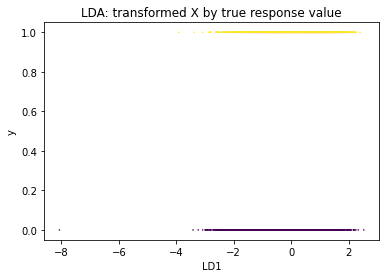

In [153]:
plt.scatter(X_lda[:, 0], y_resampled, c=y_resampled,  s=0.3)
plt.xlabel('LD1')
plt.ylabel('y')
plt.title('LDA: transformed X by true response value')
plt.show()

In [154]:
confusion_matrix(y_resampled, y_pred)

array([[2110, 1638],
       [1532, 2216]], dtype=int64)

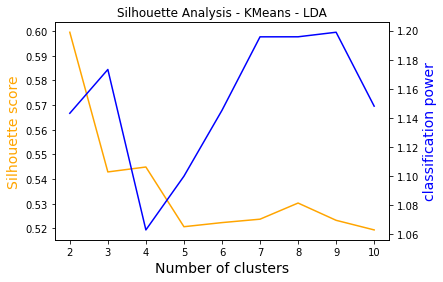

In [155]:
silhouette_scores = []
gains = []
for i in range(2, 11):
    kmeans = sklearn.cluster.KMeans(n_clusters=i, init='random',n_init=10, max_iter=300, tol=1e-04, random_state=0)
    kmeans.fit(X_lda)
    silhouette_scores.append(silhouette_score(X_lda, kmeans.labels_))
    y_km = kmeans.fit_predict(X_lda)
    result_compare = pd.DataFrame()
    result_compare['fitted'] = y_km
    result_compare['actual'] = y_resampled
    selected_group = int(s.mode(result_compare[result_compare.actual==1]['fitted'])[0])
    gain = result_compare[result_compare.fitted == selected_group]['actual'].sum() / result_compare[result_compare.fitted == selected_group]['actual'].count() / (result_compare['actual'].sum() / result_compare['actual'].count()) 
    gains.append(gain)
    
fig,ax = plt.subplots()
plt.title('Silhouette Analysis - KMeans - LDA')
# make a plot
ax.plot(range(2, 11),
        silhouette_scores,color="orange")
# set x-axis label
ax.set_xlabel("Number of clusters", fontsize = 14)
# set y-axis label
ax.set_ylabel("Silhouette score",
              color="orange",
              fontsize=14)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(range(2, 11), gains,color="blue")
ax2.set_ylabel("classification power",color="blue",fontsize=14)
plt.show()

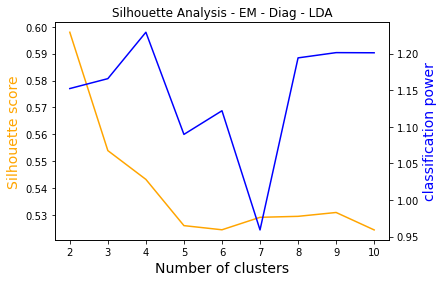

In [156]:
silhouette_scores = []
gains = []
for i in range(2, 11):
    em = sklearn.mixture.GaussianMixture(n_components=i, covariance_type='diag',n_init=10, max_iter=300)
    em.fit(X_lda)
    y_km = em.fit_predict(X_lda)
    silhouette_scores.append(silhouette_score(X_lda, y_km))
    
    result_compare = pd.DataFrame()
    result_compare['fitted'] = y_km
    result_compare['actual'] = y_resampled
    selected_group = int(s.mode(result_compare[result_compare.actual==1]['fitted'])[0])
    gain = result_compare[result_compare.fitted == selected_group]['actual'].sum() / result_compare[result_compare.fitted == selected_group]['actual'].count() / (result_compare['actual'].sum() / result_compare['actual'].count()) 
    gains.append(gain)
    
fig,ax = plt.subplots()
plt.title('Silhouette Analysis - EM - Diag - LDA')
# make a plot
ax.plot(range(2, 11),
        silhouette_scores,color="orange")
# set x-axis label
ax.set_xlabel("Number of clusters", fontsize = 14)
# set y-axis label
ax.set_ylabel("Silhouette score",
              color="orange",
              fontsize=14)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(range(2, 11), gains,color="blue")
ax2.set_ylabel("classification power",color="blue",fontsize=14)
plt.show()

### refit

In [161]:
rus = RandomUnderSampler(random_state=42)

# Resample the data
X_resampled, y_resampled = rus.fit_resample(X, y)

In [188]:
pca = PCA(n_components=5)
# Fit the PCA model to the data and transform it
X_pca = pca.fit_transform(X_resampled)
X_reconstructed = np.dot(X_pca, pca.components_)
reconstruction_error = np.mean(np.sum(np.power(X_resampled - X_reconstructed, 2), axis=1))

In [189]:
X_Train, X_Test, y_Train, y_Test = train_test_split(X_reconstructed, y_resampled, test_size=0.3, random_state=1) 
X_Train = pd.DataFrame(X_Train)
X_Test = pd.DataFrame(X_Test)
y_Train = pd.DataFrame(y_Train)
y_Test = pd.DataFrame(y_Test)

In [190]:
max_iteration = list(np.arange(6,12))

test_accuracy_list = []
test_auc_list = []
train_accuracy_list = []
train_auc_list = []
iteration_list = []
k=5
group = KFold(n_splits=k, random_state=1,shuffle=True)
training_time_series = []
for i in range(6,12):
    clf = neural_network.MLPClassifier(hidden_layer_sizes=(i,),solver= 'adam', activation='relu')

    test_agg_accu = 0
    test_agg_auc = 0
    train_agg_accu = 0
    train_agg_auc = 0
    training_time_sum = 0
    iteration_sum = 0
    for train_index, test_index in group.split(X_Train):
        X_train, X_test = X_Train.iloc[train_index], X_Train.iloc[test_index]
        Y_train, Y_test = y_Train.iloc[train_index], y_Train.iloc[test_index]
        start = time.time()
        clf = clf.fit( X_train,Y_train)
        stop = time.time()
        training_time = stop - start
        training_time_sum += training_time
        iteration_sum += clf.n_iter_
        Y_pred = clf.predict(X_test)
        Y_pred_train = clf.predict(X_train)
        test_accuracy = accuracy_score(Y_test , Y_pred)
        test_auc = roc_auc_score(Y_test , Y_pred)
        train_accuracy = accuracy_score(Y_train , Y_pred_train)
        train_auc = roc_auc_score(Y_train , Y_pred_train)
        test_agg_accu = test_agg_accu+ test_accuracy
        test_agg_auc = test_agg_auc + test_auc
        train_agg_accu = train_agg_accu + train_accuracy
        train_agg_auc = train_agg_auc + train_auc
    test_avg_accu = test_agg_accu/k
    test_avg_auc = test_agg_auc/k
    train_avg_accu = train_agg_accu/k
    train_avg_auc = train_agg_auc/k
    training_time_series.append(training_time_sum/k)
    iteration_list.append(iteration_sum/k)

    test_accuracy_list.append(1-test_avg_accu)
    test_auc_list.append(test_avg_auc)

    train_accuracy_list.append(1-train_avg_accu)
    train_auc_list.append(train_avg_auc)
        

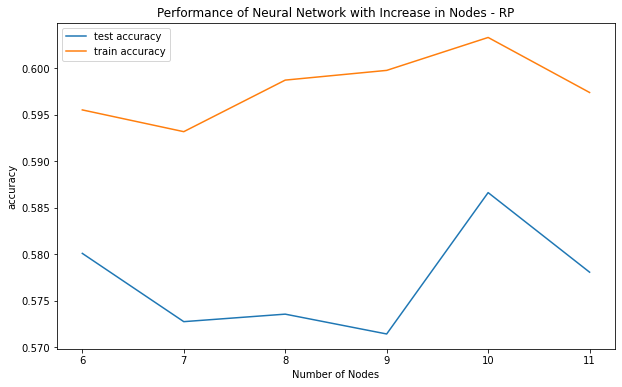

In [192]:
plt.figure(figsize=(10, 6)) 
plt.plot(max_iteration ,test_auc_list, label = "test accuracy")
plt.plot(max_iteration ,train_auc_list, label = "train accuracy")
plt.legend(loc="upper left")    
plt.title('Performance of Neural Network with Increase in Nodes - RP')
plt.xlabel('Number of Nodes')
plt.ylabel('accuracy')
plt.show()

In [213]:
max_iteration = list(np.arange(3,12))

test_accuracy_list = []
test_auc_list = []
train_accuracy_list = []
train_auc_list = []
iteration_list = []
k=5
group = KFold(n_splits=k, random_state=1,shuffle=True)
training_time_series = []
for i in range(3,12):
    
    kmeans = sklearn.cluster.KMeans(n_clusters=i, init='random',n_init=10, max_iter=300, tol=1e-04, random_state=0)
    kmeans.fit(X_resampled)
    y_km = kmeans.fit_predict(X_resampled)
    
    
    X_Train, X_Test, y_Train, y_Test = train_test_split(y_km, y_resampled, test_size=0.3, random_state=1) 
    X_Train = pd.DataFrame(X_Train)
    X_Test = pd.DataFrame(X_Test)
    y_Train = pd.DataFrame(y_Train)
    y_Test = pd.DataFrame(y_Test)
    
    clf = neural_network.MLPClassifier(hidden_layer_sizes=(10,),solver= 'adam', activation='relu')

    test_agg_accu = 0
    test_agg_auc = 0
    train_agg_accu = 0
    train_agg_auc = 0
    training_time_sum = 0
    iteration_sum = 0
    for train_index, test_index in group.split(X_Train):
        X_train, X_test = X_Train.iloc[train_index], X_Train.iloc[test_index]
        Y_train, Y_test = y_Train.iloc[train_index], y_Train.iloc[test_index]
        start = time.time()
        clf = clf.fit( X_train,Y_train)
        stop = time.time()
        training_time = stop - start
        training_time_sum += training_time
        iteration_sum += clf.n_iter_
        Y_pred = clf.predict(X_test)
        Y_pred_train = clf.predict(X_train)
        test_accuracy = accuracy_score(Y_test , Y_pred)
        test_auc = roc_auc_score(Y_test , Y_pred)
        train_accuracy = accuracy_score(Y_train , Y_pred_train)
        train_auc = roc_auc_score(Y_train , Y_pred_train)
        test_agg_accu = test_agg_accu+ test_accuracy
        test_agg_auc = test_agg_auc + test_auc
        train_agg_accu = train_agg_accu + train_accuracy
        train_agg_auc = train_agg_auc + train_auc
    test_avg_accu = test_agg_accu/k
    test_avg_auc = test_agg_auc/k
    train_avg_accu = train_agg_accu/k
    train_avg_auc = train_agg_auc/k
    training_time_series.append(training_time_sum/k)
    iteration_list.append(iteration_sum/k)

    test_accuracy_list.append(1-test_avg_accu)
    test_auc_list.append(test_avg_auc)

    train_accuracy_list.append(1-train_avg_accu)
    train_auc_list.append(train_avg_auc)
        

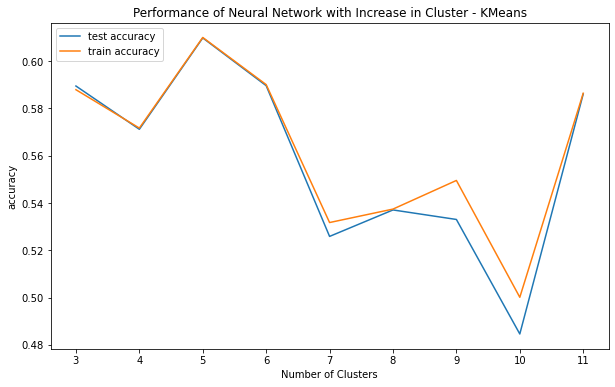

In [214]:
plt.figure(figsize=(10, 6)) 
plt.plot(max_iteration ,test_auc_list, label = "test accuracy")
plt.plot(max_iteration ,train_auc_list, label = "train accuracy")
plt.legend(loc="upper left")    
plt.title('Performance of Neural Network with Increase in Cluster - KMeans')
plt.xlabel('Number of Clusters')
plt.ylabel('accuracy')
plt.show()